In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tensorflow

In [2]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os

## Merging original features and best features

In [2]:
data = pd.read_pickle('./temp/data.pkl')

In [3]:
best_features = pd.read_parquet('./FE2/Corr_features_3155.pqt')


In [4]:
best_features['userid'] = data['userid']


In [5]:
for i in range(30):
    best_features[f'field{i}'] = data[f'field{i}']
    best_features[f'goal1'] = data[f'goal1']
for i in range(1,6):
    best_features[f'indicator_goal2{i}'] = data[f'indicator_goal2{i}']
    best_features[f'goal2{i}'] = data[f'goal2{i}']

In [10]:
del data
gc.collect()

0

In [6]:
for col in best_features.columns:
    if best_features[col].dtypes.name == 'object':
        best_features[col] = pd.Categorical(best_features[col])

In [7]:
best_features.to_parquet("./FE2/BEST3155+Orig.pqt")

In [9]:
best_features.index

Int64Index([1000000, 1000001, 1000002, 1000003, 1000004, 1000005, 1000006,
            1000007, 1000008, 1000009,
            ...
             455001,  455002,  455003,  455004,  455005,  455006,  455007,
             455008,  455009,  455010],
           dtype='int64', name='orderid', length=651067)

## Training


In [4]:
import dask.dataframe as dd
best_features = pd.read_parquet("./FE2/BEST3155+Orig.pqt")

In [5]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23','field12',
       'goal24', 'goal25', 'goal1','userid', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country']

In [6]:
train_idx = best_features[best_features['goal1']>=0].index
test_idx = best_features[best_features['goal1']<0].index
X = best_features.loc[train_idx]
y = best_features[best_features['goal1']>=0]['goal1']
test=best_features.loc[test_idx]
train_features = [f for f in best_features.columns if f not in exclude_features_from_training]

In [15]:
# del best_features
# gc.collect()

31100

In [7]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.utils import check_random_state

class RepeatedStratifiedGroupKFold():

    def __init__(self, n_splits=5, n_repeats=1, random_state=69):
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.random_state = random_state
        
    # Implementation based on this kaggle kernel:
    #    https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    def split(self, X, y=None, groups=None):
        k = self.n_splits
        def eval_y_counts_per_fold(y_counts, fold):
            y_counts_per_fold[fold] += y_counts
            std_per_label = []
            for label in range(labels_num):
                label_std = np.std(
                    [y_counts_per_fold[i][label] / y_distr[label] for i in range(k)]
                )
                std_per_label.append(label_std)
            y_counts_per_fold[fold] -= y_counts
            return np.mean(std_per_label)
            
        rnd = check_random_state(self.random_state)
        for repeat in range(self.n_repeats):
            labels_num = np.max(y) + 1
            y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
            y_distr = Counter()
            for label, g in zip(y, groups):
                y_counts_per_group[g][label] += 1
                y_distr[label] += 1

            y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
            groups_per_fold = defaultdict(set)
        
            groups_and_y_counts = list(y_counts_per_group.items())
            rnd.shuffle(groups_and_y_counts)

            for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
                best_fold = None
                min_eval = None
                for i in range(k):
                    fold_eval = eval_y_counts_per_fold(y_counts, i)
                    if min_eval is None or fold_eval < min_eval:
                        min_eval = fold_eval
                        best_fold = i
                y_counts_per_fold[best_fold] += y_counts
                groups_per_fold[best_fold].add(g)

            all_groups = set(groups)
            for i in range(k):
                train_groups = all_groups - groups_per_fold[i]
                test_groups = groups_per_fold[i]

                train_indices = [i for i, g in enumerate(groups) if g in train_groups]
                test_indices = [i for i, g in enumerate(groups) if g in test_groups]

                yield train_indices, test_indices

In [8]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 3000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

In [9]:
y = y.astype(np.uint8)

Fold 1 started at Fri Jan 10 18:42:40 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.711483	training's auc: 0.711481	valid_1's auc: 0.698136	valid_1's auc: 0.698145
[200]	training's auc: 0.725807	training's auc: 0.725807	valid_1's auc: 0.704334	valid_1's auc: 0.704335
[300]	training's auc: 0.737216	training's auc: 0.737216	valid_1's auc: 0.708803	valid_1's auc: 0.708803
[400]	training's auc: 0.748113	training's auc: 0.748113	valid_1's auc: 0.712596	valid_1's auc: 0.712596
[500]	training's auc: 0.757627	training's auc: 0.757627	valid_1's auc: 0.714213	valid_1's auc: 0.714213
[600]	training's auc: 0.765708	training's auc: 0.765708	valid_1's auc: 0.715192	valid_1's auc: 0.715192
[700]	training's auc: 0.773055	training's auc: 0.773055	valid_1's auc: 0.716888	valid_1's auc: 0.716888
[800]	training's auc: 0.778936	training's auc: 0.778936	valid_1's auc: 0.718209	valid_1's auc: 0.71821
[900]	training's auc: 0.784652	training's auc: 0.784652	valid_1

[600]	training's auc: 0.766371	training's auc: 0.76637	valid_1's auc: 0.698712	valid_1's auc: 0.698712
[700]	training's auc: 0.773521	training's auc: 0.773521	valid_1's auc: 0.698833	valid_1's auc: 0.698833
[800]	training's auc: 0.779758	training's auc: 0.779758	valid_1's auc: 0.699347	valid_1's auc: 0.699346
[900]	training's auc: 0.785033	training's auc: 0.785033	valid_1's auc: 0.699905	valid_1's auc: 0.699905
[1000]	training's auc: 0.789876	training's auc: 0.789876	valid_1's auc: 0.700226	valid_1's auc: 0.700226
[1100]	training's auc: 0.794254	training's auc: 0.794254	valid_1's auc: 0.700661	valid_1's auc: 0.700661
[1200]	training's auc: 0.798703	training's auc: 0.798703	valid_1's auc: 0.701261	valid_1's auc: 0.701261
[1300]	training's auc: 0.802861	training's auc: 0.802861	valid_1's auc: 0.701463	valid_1's auc: 0.701463
[1400]	training's auc: 0.806864	training's auc: 0.806864	valid_1's auc: 0.701521	valid_1's auc: 0.701521
[1500]	training's auc: 0.810897	training's auc: 0.810897	val

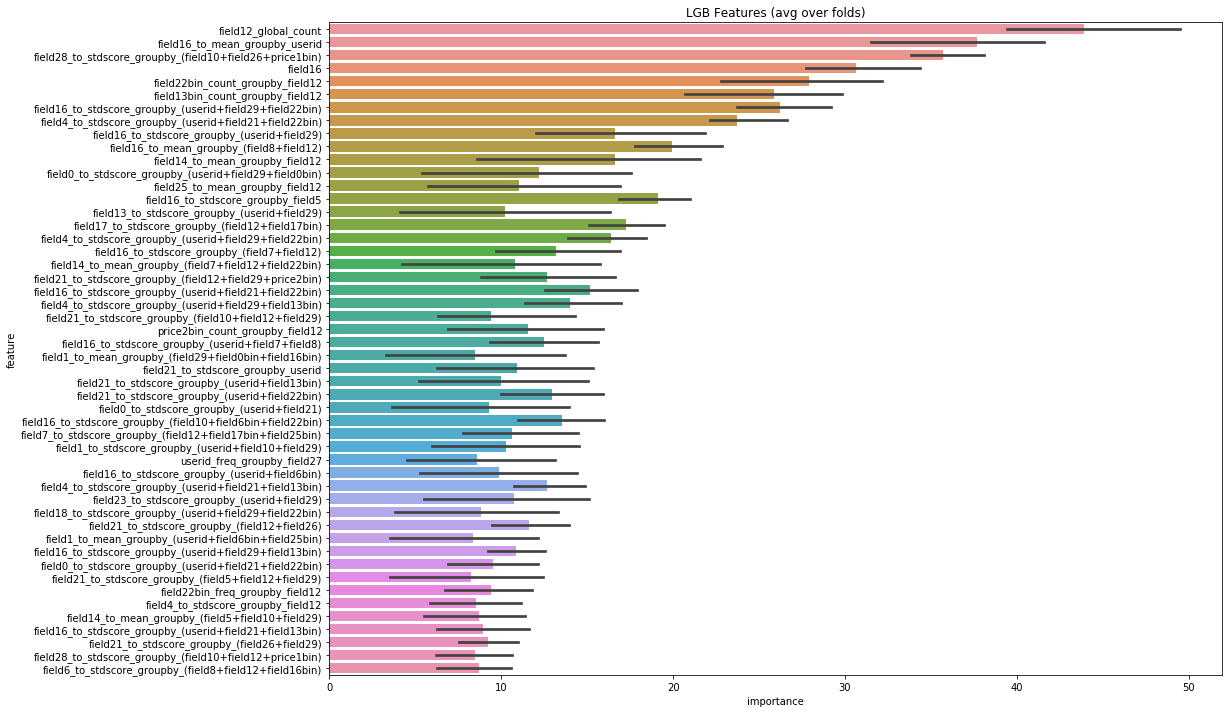

In [10]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

## 1236 best features

Fold 1 started at Tue Jan  7 20:49:21 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.709081	training's auc: 0.709079	valid_1's auc: 0.693037	valid_1's auc: 0.693043
[200]	training's auc: 0.720758	training's auc: 0.720758	valid_1's auc: 0.695446	valid_1's auc: 0.695445
[300]	training's auc: 0.729458	training's auc: 0.729458	valid_1's auc: 0.697883	valid_1's auc: 0.697883
[400]	training's auc: 0.73913	training's auc: 0.73913	valid_1's auc: 0.699906	valid_1's auc: 0.699906
[500]	training's auc: 0.747183	training's auc: 0.747183	valid_1's auc: 0.701917	valid_1's auc: 0.701917
[600]	training's auc: 0.754383	training's auc: 0.754383	valid_1's auc: 0.702833	valid_1's auc: 0.702833
[700]	training's auc: 0.76048	training's auc: 0.76048	valid_1's auc: 0.703841	valid_1's auc: 0.703841
[800]	training's auc: 0.765831	training's auc: 0.765831	valid_1's auc: 0.704398	valid_1's auc: 0.704398
[900]	training's auc: 0.771488	training's auc: 0.771488	valid_1's 

[1000]	training's auc: 0.778577	training's auc: 0.778577	valid_1's auc: 0.70036	valid_1's auc: 0.70036
[1100]	training's auc: 0.783786	training's auc: 0.783786	valid_1's auc: 0.70111	valid_1's auc: 0.70111
[1200]	training's auc: 0.788861	training's auc: 0.788861	valid_1's auc: 0.701454	valid_1's auc: 0.701454
[1300]	training's auc: 0.793569	training's auc: 0.793569	valid_1's auc: 0.701776	valid_1's auc: 0.701776
[1400]	training's auc: 0.798592	training's auc: 0.798592	valid_1's auc: 0.702357	valid_1's auc: 0.702357
[1500]	training's auc: 0.803151	training's auc: 0.803151	valid_1's auc: 0.702344	valid_1's auc: 0.702344
[1600]	training's auc: 0.807224	training's auc: 0.807224	valid_1's auc: 0.702575	valid_1's auc: 0.702575
[1700]	training's auc: 0.811073	training's auc: 0.811073	valid_1's auc: 0.70265	valid_1's auc: 0.70265
[1800]	training's auc: 0.814595	training's auc: 0.814595	valid_1's auc: 0.702965	valid_1's auc: 0.702965
[1900]	training's auc: 0.818182	training's auc: 0.818182	vali

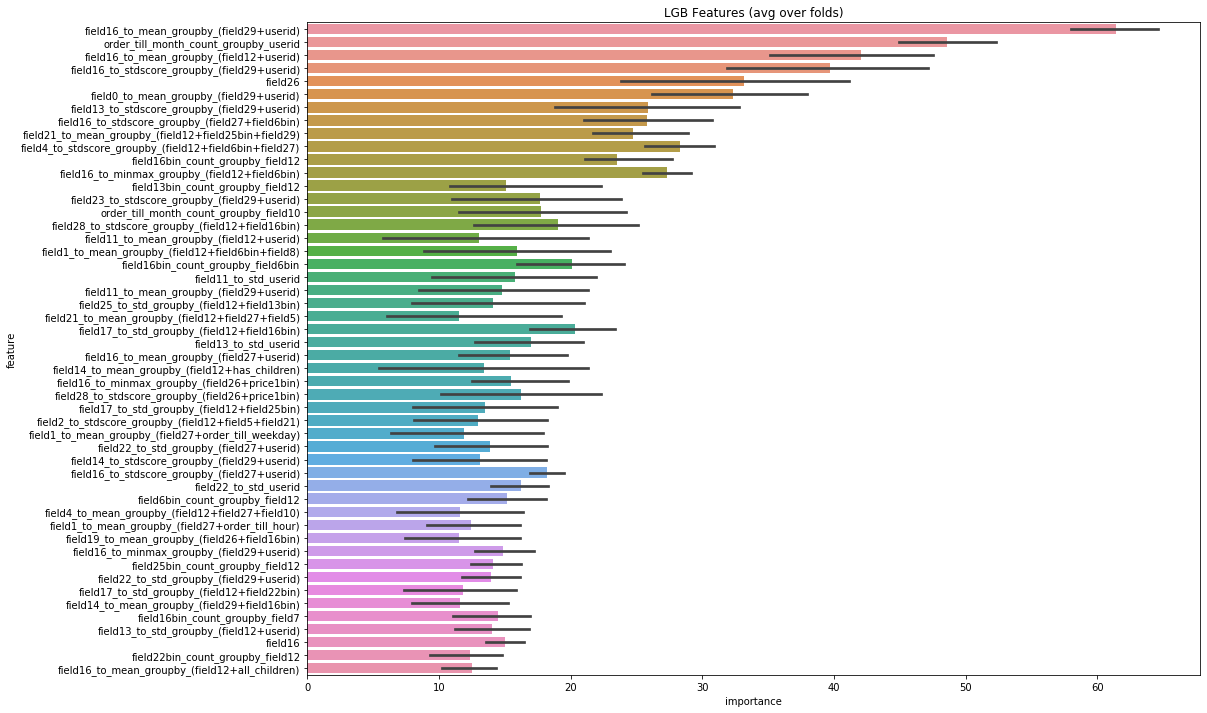

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan  5 20:11:57 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.710042	training's auc: 0.710038	valid_1's auc: 0.678083	valid_1's auc: 0.678086
[200]	training's auc: 0.71992	training's auc: 0.71992	valid_1's auc: 0.68439	valid_1's auc: 0.684389
[300]	training's auc: 0.728749	training's auc: 0.728749	valid_1's auc: 0.688293	valid_1's auc: 0.688292
[400]	training's auc: 0.738816	training's auc: 0.738816	valid_1's auc: 0.692338	valid_1's auc: 0.692338
[500]	training's auc: 0.747321	training's auc: 0.747321	valid_1's auc: 0.693523	valid_1's auc: 0.693523
[600]	training's auc: 0.754559	training's auc: 0.754559	valid_1's auc: 0.694666	valid_1's auc: 0.694666
[700]	training's auc: 0.760856	training's auc: 0.760856	valid_1's auc: 0.695686	valid_1's auc: 0.695686
[800]	training's auc: 0.76664	training's auc: 0.76664	valid_1's auc: 0.696014	valid_1's auc: 0.696014
[900]	training's auc: 0.771861	training's auc: 0.771861	valid_1's a

[600]	training's auc: 0.753367	training's auc: 0.753367	valid_1's auc: 0.700802	valid_1's auc: 0.700802
[700]	training's auc: 0.75858	training's auc: 0.75858	valid_1's auc: 0.702144	valid_1's auc: 0.702144
[800]	training's auc: 0.763847	training's auc: 0.763847	valid_1's auc: 0.703055	valid_1's auc: 0.703055
[900]	training's auc: 0.769042	training's auc: 0.769042	valid_1's auc: 0.703797	valid_1's auc: 0.703797
[1000]	training's auc: 0.77416	training's auc: 0.77416	valid_1's auc: 0.704778	valid_1's auc: 0.704778
[1100]	training's auc: 0.778642	training's auc: 0.778642	valid_1's auc: 0.705681	valid_1's auc: 0.705681
[1200]	training's auc: 0.782984	training's auc: 0.782984	valid_1's auc: 0.705775	valid_1's auc: 0.705775
[1300]	training's auc: 0.787503	training's auc: 0.787503	valid_1's auc: 0.705934	valid_1's auc: 0.705934
[1400]	training's auc: 0.79206	training's auc: 0.79206	valid_1's auc: 0.706001	valid_1's auc: 0.706001
[1500]	training's auc: 0.796255	training's auc: 0.796255	valid_1'

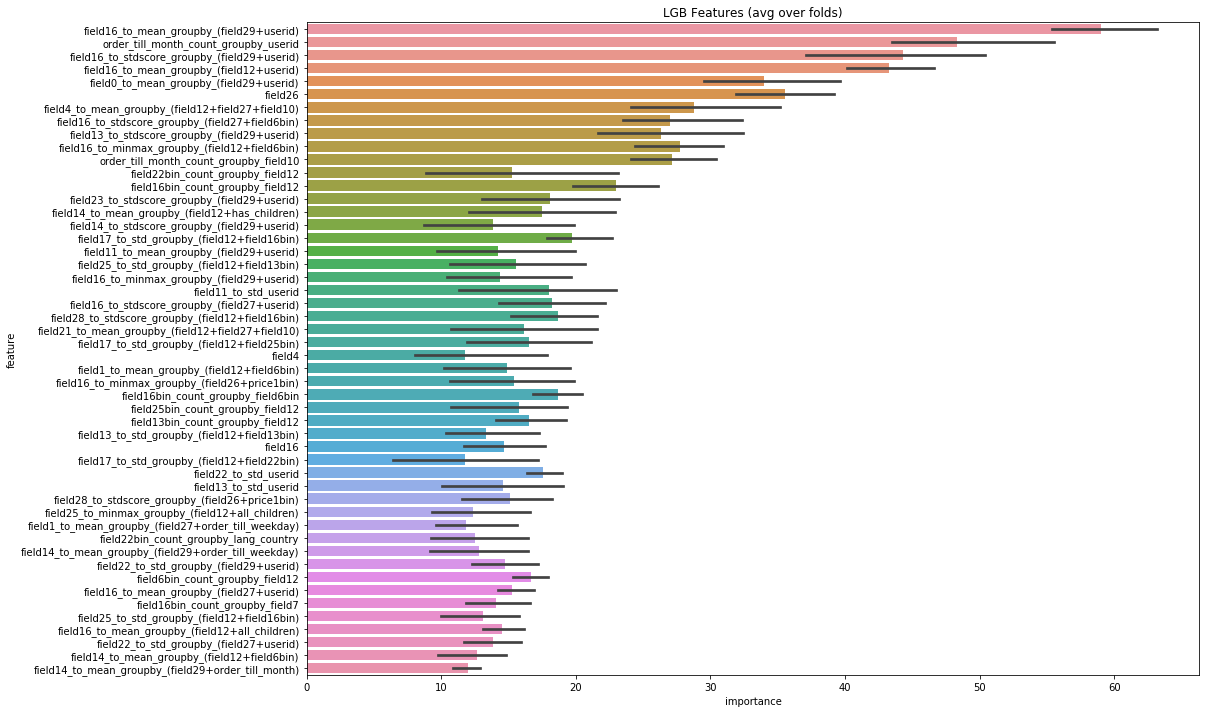

In [34]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### PREVIOUS

Fold 1 started at Sun Jan  5 19:32:23 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.709847	training's auc: 0.709849	valid_1's auc: 0.667254	valid_1's auc: 0.667242
[200]	training's auc: 0.722829	training's auc: 0.722829	valid_1's auc: 0.673033	valid_1's auc: 0.673033
[300]	training's auc: 0.732897	training's auc: 0.732897	valid_1's auc: 0.677898	valid_1's auc: 0.677898
[400]	training's auc: 0.743508	training's auc: 0.743508	valid_1's auc: 0.680865	valid_1's auc: 0.680865
[500]	training's auc: 0.751759	training's auc: 0.751759	valid_1's auc: 0.681824	valid_1's auc: 0.681824
[600]	training's auc: 0.759455	training's auc: 0.759455	valid_1's auc: 0.682964	valid_1's auc: 0.682964
[700]	training's auc: 0.765775	training's auc: 0.765775	valid_1's auc: 0.683873	valid_1's auc: 0.683873
[800]	training's auc: 0.771203	training's auc: 0.771203	valid_1's auc: 0.684521	valid_1's auc: 0.684521
[900]	training's auc: 0.776501	training's auc: 0.776501	valid_

[700]	training's auc: 0.762697	training's auc: 0.762697	valid_1's auc: 0.693759	valid_1's auc: 0.693759
[800]	training's auc: 0.768836	training's auc: 0.768836	valid_1's auc: 0.695172	valid_1's auc: 0.695172
[900]	training's auc: 0.774507	training's auc: 0.774507	valid_1's auc: 0.695841	valid_1's auc: 0.695841
[1000]	training's auc: 0.779674	training's auc: 0.779674	valid_1's auc: 0.696618	valid_1's auc: 0.696618
[1100]	training's auc: 0.784285	training's auc: 0.784285	valid_1's auc: 0.696992	valid_1's auc: 0.696992
[1200]	training's auc: 0.788962	training's auc: 0.788962	valid_1's auc: 0.697555	valid_1's auc: 0.697555
[1300]	training's auc: 0.793333	training's auc: 0.793333	valid_1's auc: 0.698095	valid_1's auc: 0.698095
[1400]	training's auc: 0.79761	training's auc: 0.79761	valid_1's auc: 0.698323	valid_1's auc: 0.698323
[1500]	training's auc: 0.801675	training's auc: 0.801675	valid_1's auc: 0.698498	valid_1's auc: 0.698498
[1600]	training's auc: 0.805368	training's auc: 0.805368	val

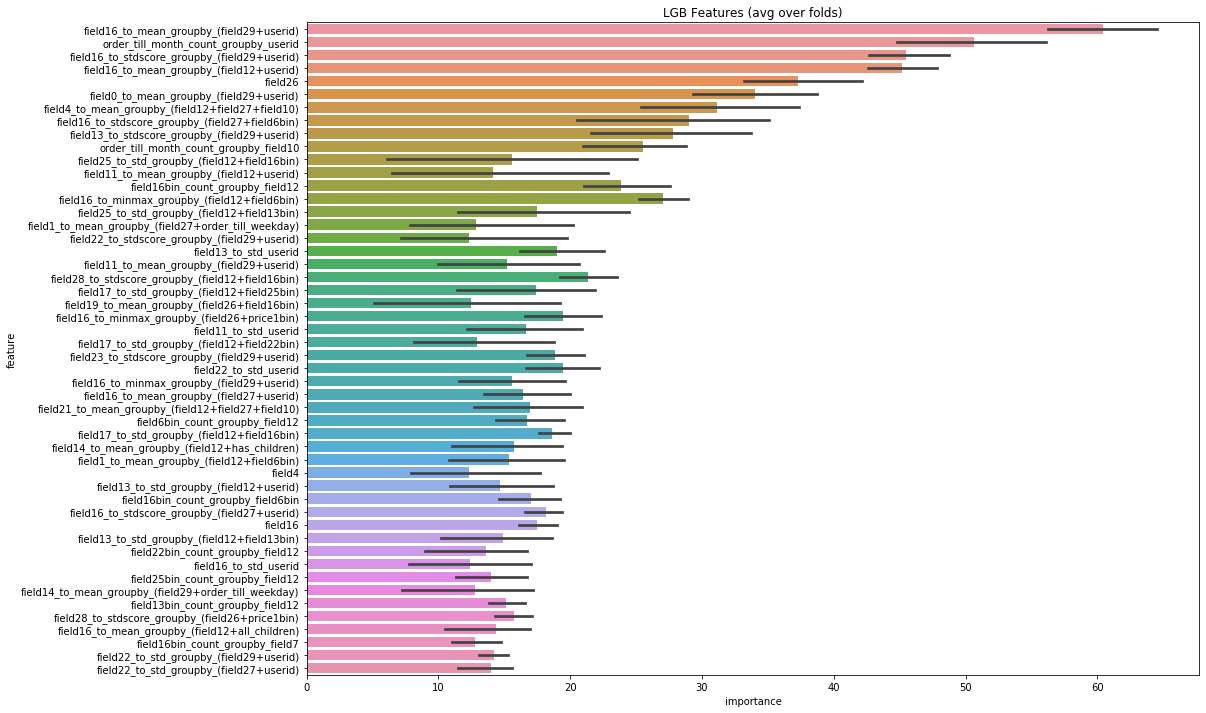

In [14]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [16]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 1000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sun Jan  5 18:55:21 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.722735	training's auc: 0.722737	valid_1's auc: 0.67203	valid_1's auc: 0.67203
[200]	training's auc: 0.742866	training's auc: 0.742865	valid_1's auc: 0.679624	valid_1's auc: 0.679625
[300]	training's auc: 0.759112	training's auc: 0.759112	valid_1's auc: 0.682494	valid_1's auc: 0.682494
[400]	training's auc: 0.771008	training's auc: 0.771008	valid_1's auc: 0.684199	valid_1's auc: 0.684199
[500]	training's auc: 0.780192	training's auc: 0.780192	valid_1's auc: 0.684454	valid_1's auc: 0.684454
[600]	training's auc: 0.788647	training's auc: 0.788647	valid_1's auc: 0.684897	valid_1's auc: 0.684897
[700]	training's auc: 0.796798	training's auc: 0.796798	valid_1's auc: 0.684732	valid_1's auc: 0.684732
Early stopping, best iteration is:
[648]	training's auc: 0.79246	training's auc: 0.79246	valid_1's auc: 0.684971	valid_1's auc: 0.684971
Fold 2 started at Sun Jan  5 18

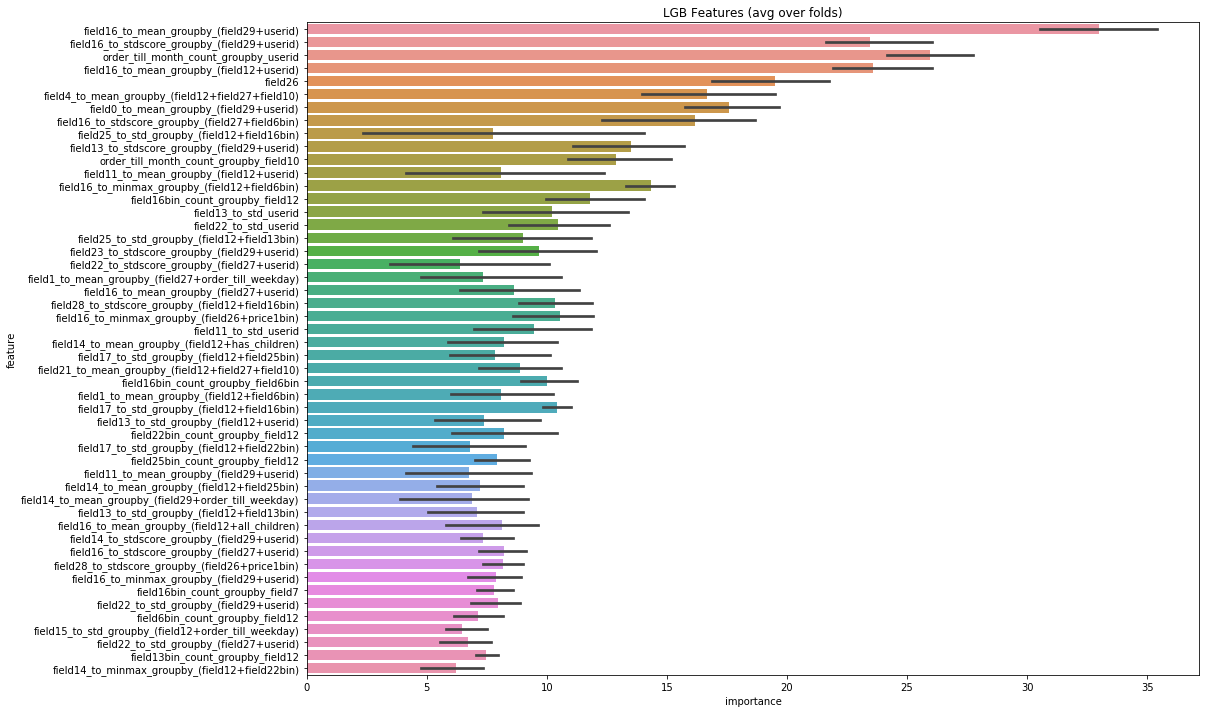

In [17]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan  5 17:48:03 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.753482	training's auc: 0.753443	valid_1's auc: 0.662721	valid_1's auc: 0.662544
[200]	training's auc: 0.798471	training's auc: 0.798467	valid_1's auc: 0.670129	valid_1's auc: 0.670119
[300]	training's auc: 0.832729	training's auc: 0.832729	valid_1's auc: 0.677323	valid_1's auc: 0.677324
[400]	training's auc: 0.861423	training's auc: 0.861423	valid_1's auc: 0.680364	valid_1's auc: 0.680364
[500]	training's auc: 0.882461	training's auc: 0.882462	valid_1's auc: 0.682748	valid_1's auc: 0.682748
[600]	training's auc: 0.902113	training's auc: 0.902112	valid_1's auc: 0.683905	valid_1's auc: 0.683905
[700]	training's auc: 0.918472	training's auc: 0.918472	valid_1's auc: 0.686804	valid_1's auc: 0.686804
[800]	training's auc: 0.931405	training's auc: 0.931405	valid_1's auc: 0.687276	valid_1's auc: 0.687276
Early stopping, best iteration is:
[796]	training's auc: 0.930

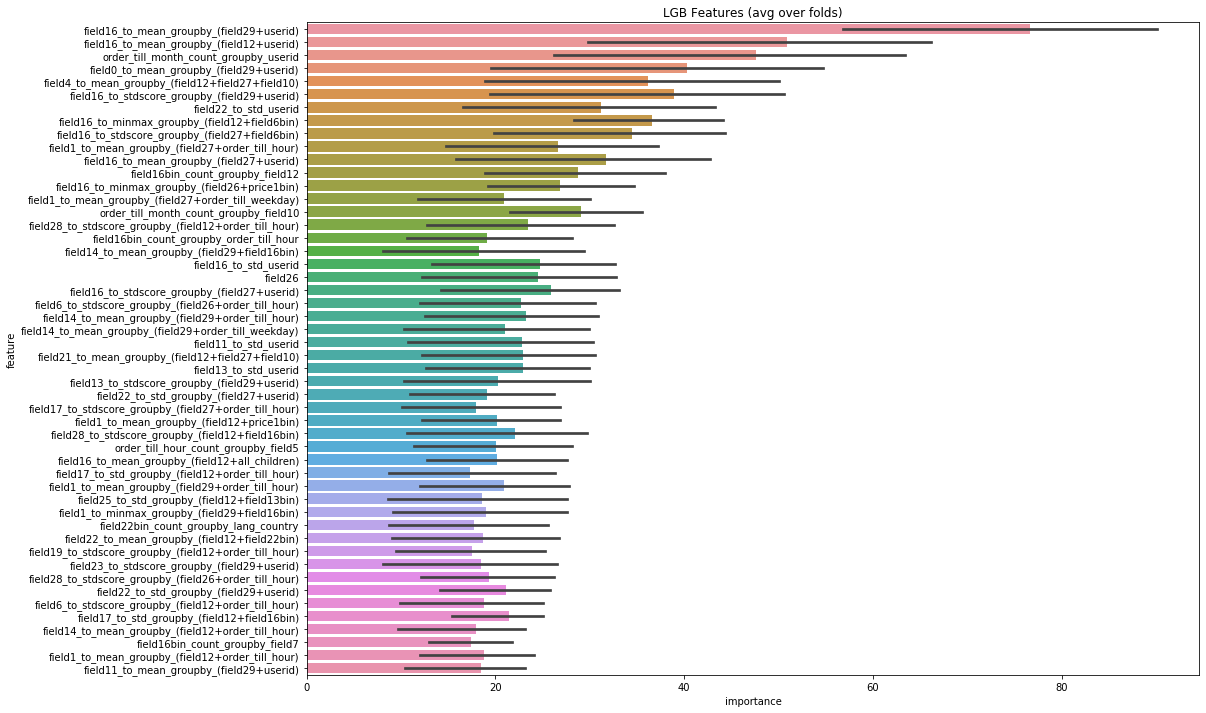

In [12]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan  4 14:29:13 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.797201	training's auc: 0.797202	valid_1's auc: 0.670295	valid_1's auc: 0.670299
[200]	training's auc: 0.859572	training's auc: 0.859572	valid_1's auc: 0.682299	valid_1's auc: 0.682299
[300]	training's auc: 0.901514	training's auc: 0.901514	valid_1's auc: 0.68417	valid_1's auc: 0.68417
[400]	training's auc: 0.929149	training's auc: 0.929149	valid_1's auc: 0.684377	valid_1's auc: 0.684377
Early stopping, best iteration is:
[367]	training's auc: 0.92024	training's auc: 0.92024	valid_1's auc: 0.684642	valid_1's auc: 0.684642
Fold 2 started at Sat Jan  4 14:34:05 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.792754	training's auc: 0.792753	valid_1's auc: 0.719666	valid_1's auc: 0.71967
[200]	training's auc: 0.854274	training's auc: 0.854273	valid_1's auc: 0.726832	valid_1's auc: 0.726833
[300]	training's auc: 0.900796

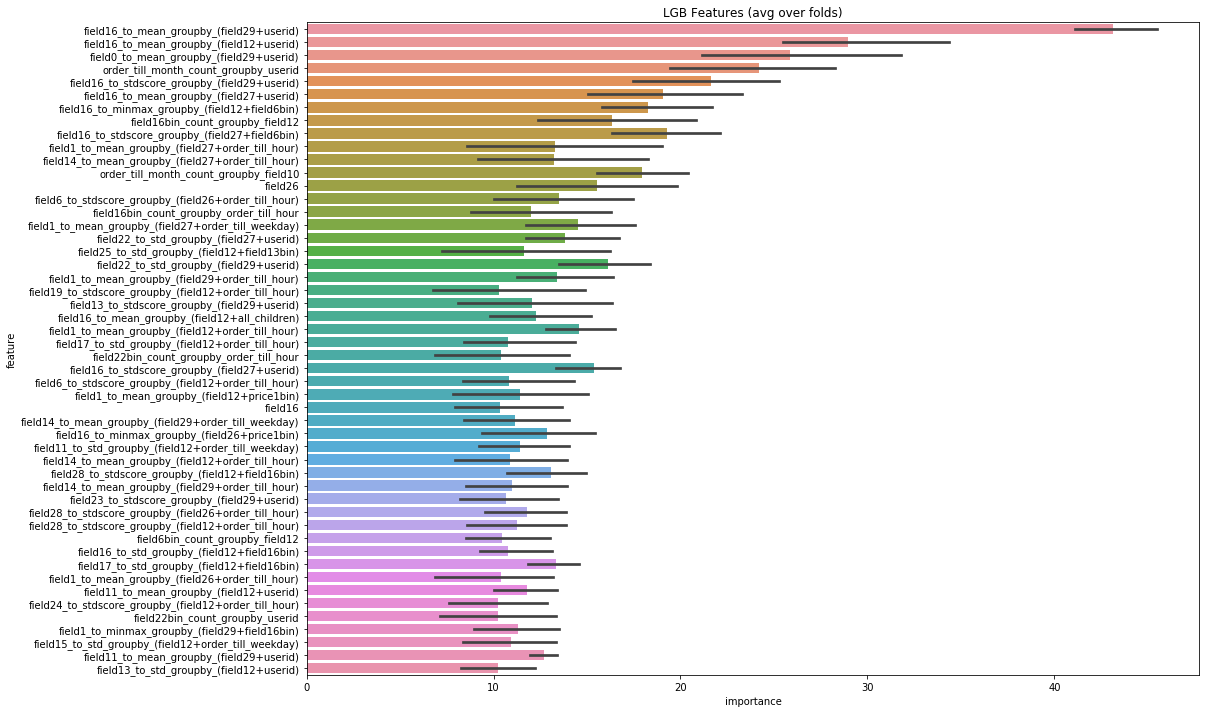

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan  4 00:16:16 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.746556	training's auc: 0.746542	valid_1's auc: 0.662057	valid_1's auc: 0.661889
[200]	training's auc: 0.782639	training's auc: 0.782646	valid_1's auc: 0.670029	valid_1's auc: 0.67003
[300]	training's auc: 0.815747	training's auc: 0.815747	valid_1's auc: 0.675619	valid_1's auc: 0.675618
[400]	training's auc: 0.844988	training's auc: 0.844989	valid_1's auc: 0.676379	valid_1's auc: 0.676379
[500]	training's auc: 0.866748	training's auc: 0.866748	valid_1's auc: 0.678385	valid_1's auc: 0.678385
[600]	training's auc: 0.885753	training's auc: 0.885753	valid_1's auc: 0.678988	valid_1's auc: 0.678988
[700]	training's auc: 0.903013	training's auc: 0.903013	valid_1's auc: 0.679358	valid_1's auc: 0.679358
[800]	training's auc: 0.916768	training's auc: 0.916768	valid_1's auc: 0.679804	valid_1's auc: 0.679804
[900]	training's auc: 0.928922	training's auc: 0.928922	valid_1

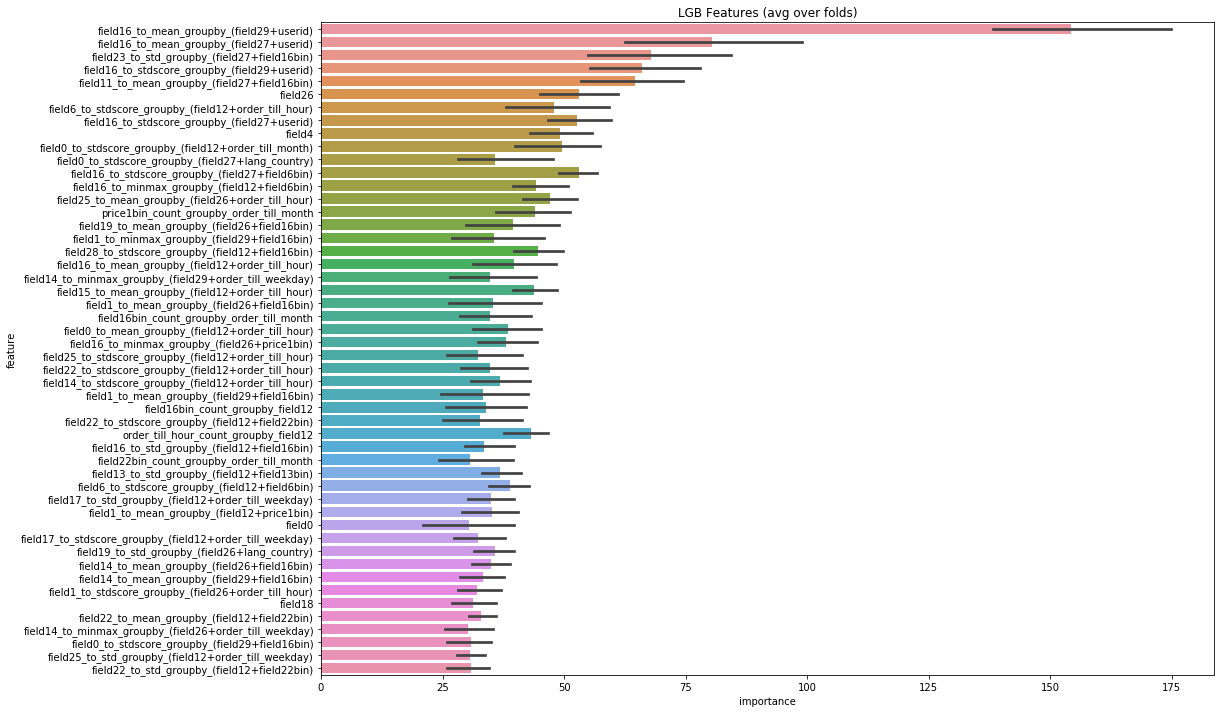

In [18]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan  3 21:08:48 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.730488	training's auc: 0.730467	valid_1's auc: 0.659146	valid_1's auc: 0.65916
[200]	training's auc: 0.767492	training's auc: 0.767488	valid_1's auc: 0.66742	valid_1's auc: 0.667414
[300]	training's auc: 0.796697	training's auc: 0.796698	valid_1's auc: 0.672982	valid_1's auc: 0.672978
[400]	training's auc: 0.823394	training's auc: 0.823394	valid_1's auc: 0.675598	valid_1's auc: 0.675597
[500]	training's auc: 0.845877	training's auc: 0.845877	valid_1's auc: 0.675653	valid_1's auc: 0.675653
Early stopping, best iteration is:
[414]	training's auc: 0.826622	training's auc: 0.826623	valid_1's auc: 0.675732	valid_1's auc: 0.675732
Fold 2 started at Fri Jan  3 21:10:31 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.730909	training's auc: 0.73095	valid_1's auc: 0.704397	valid_1's auc: 0.704421
[200]	training's auc: 0.7679

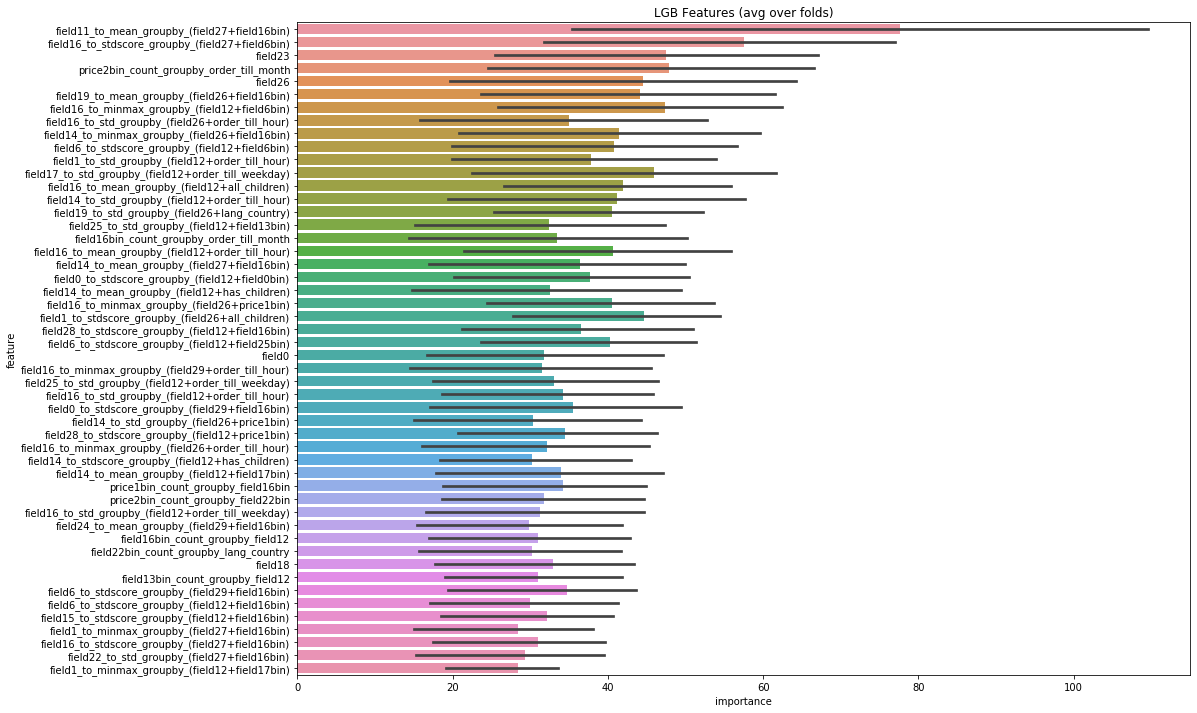

In [33]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan  3 20:11:47 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.714071	training's auc: 0.714056	valid_1's auc: 0.653947	valid_1's auc: 0.654007
Early stopping, best iteration is:
[26]	training's auc: 0.691099	training's auc: 0.69106	valid_1's auc: 0.657657	valid_1's auc: 0.657594
Fold 2 started at Fri Jan  3 20:11:57 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.701145	training's auc: 0.701186	valid_1's auc: 0.708607	valid_1's auc: 0.708571
[200]	training's auc: 0.720136	training's auc: 0.720142	valid_1's auc: 0.710664	valid_1's auc: 0.710638
[300]	training's auc: 0.743753	training's auc: 0.743748	valid_1's auc: 0.711764	valid_1's auc: 0.711751
[400]	training's auc: 0.76013	training's auc: 0.760129	valid_1's auc: 0.711556	valid_1's auc: 0.711552
[500]	training's auc: 0.777258	training's auc: 0.777259	valid_1's auc: 0.71371	valid_1's auc: 0.713709
Did not meet early stopping. 

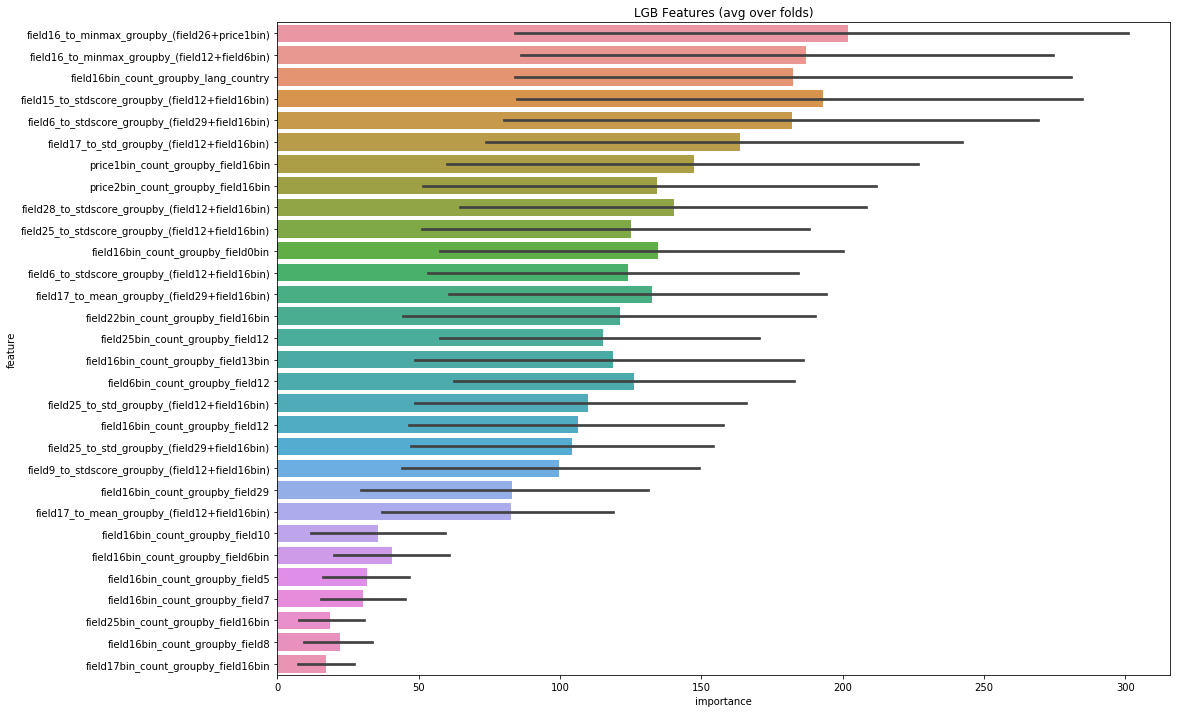

In [17]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Dec 20 08:09:14 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783373	training's auc: 0.783376	valid_1's auc: 0.672257	valid_1's auc: 0.672271
[200]	training's auc: 0.838349	training's auc: 0.83835	valid_1's auc: 0.681522	valid_1's auc: 0.681522
[300]	training's auc: 0.877625	training's auc: 0.877625	valid_1's auc: 0.68447	valid_1's auc: 0.68447
[400]	training's auc: 0.901645	training's auc: 0.901645	valid_1's auc: 0.684089	valid_1's auc: 0.684089
Early stopping, best iteration is:
[322]	training's auc: 0.884313	training's auc: 0.884313	valid_1's auc: 0.684702	valid_1's auc: 0.684702
Fold 2 started at Fri Dec 20 08:14:27 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.77402	training's auc: 0.774022	valid_1's auc: 0.718327	valid_1's auc: 0.718332
[200]	training's auc: 0.834075	training's auc: 0.834075	valid_1's auc: 0.726482	valid_1's auc: 0.726481
[300]	training's auc: 0.87351

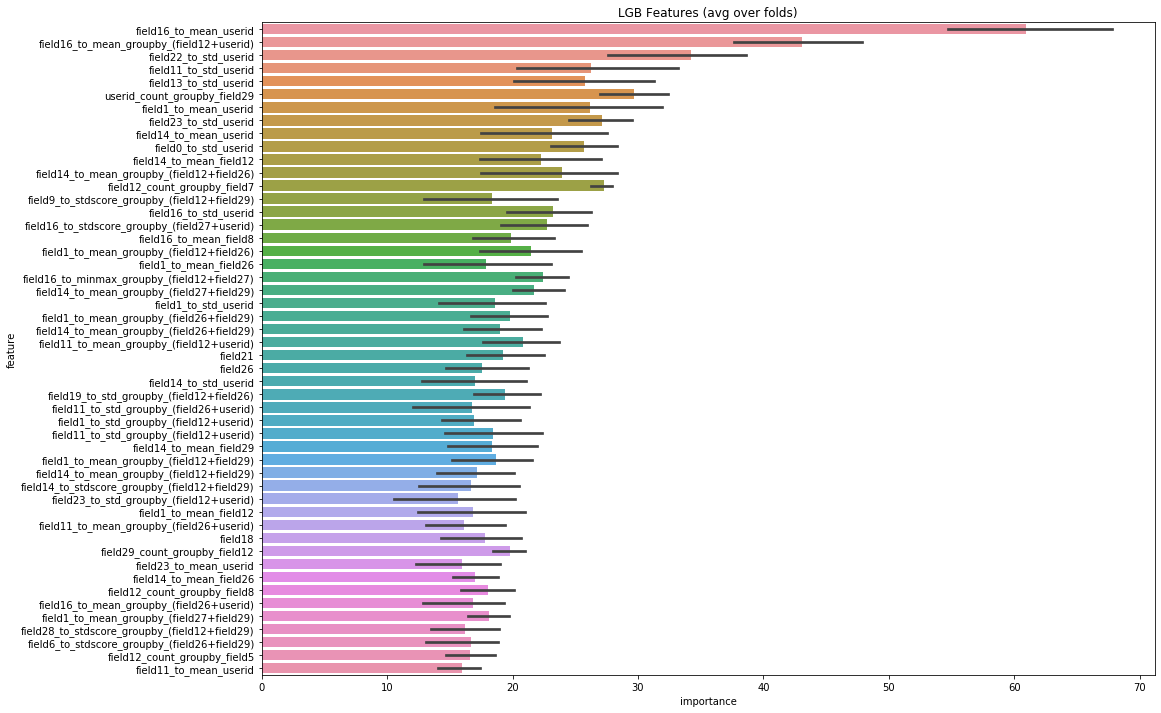

In [72]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [11]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'temp/submission-{t}.csv')

import pickle
pickle.dump(result_dict, open(f'temp/submission-{t}.pkl','wb'))

## Goal2

In [36]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

In [46]:
gc.collect()

354

In [38]:
sub2 = pd.read_csv('data/onetwotrip_challenge_sub2.csv')

In [39]:
sub2.columns = ['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']
sub2 = pd.DataFrame(0, columns=sub2.columns, index=sub2.index)

Goal  1
Fold 1 started at Sun Jan  5 21:15:27 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.71544	training's auc: 0.715442	valid_1's auc: 0.7165	valid_1's auc: 0.716445
[200]	training's auc: 0.72328	training's auc: 0.723281	valid_1's auc: 0.720645	valid_1's auc: 0.720643
[300]	training's auc: 0.730429	training's auc: 0.730429	valid_1's auc: 0.722425	valid_1's auc: 0.722425
[400]	training's auc: 0.737311	training's auc: 0.737311	valid_1's auc: 0.725314	valid_1's auc: 0.725314
[500]	training's auc: 0.742654	training's auc: 0.742654	valid_1's auc: 0.727404	valid_1's auc: 0.727404
[600]	training's auc: 0.746959	training's auc: 0.746959	valid_1's auc: 0.728532	valid_1's auc: 0.728532
[700]	training's auc: 0.751133	training's auc: 0.751133	valid_1's auc: 0.72906	valid_1's auc: 0.72906
[800]	training's auc: 0.755381	training's auc: 0.755381	valid_1's auc: 0.729216	valid_1's auc: 0.729216
[900]	training's auc: 0.759224	training's auc: 0.759224	vali

[1000]	training's auc: 0.770899	training's auc: 0.770899	valid_1's auc: 0.694671	valid_1's auc: 0.694671
[1100]	training's auc: 0.774391	training's auc: 0.774391	valid_1's auc: 0.695147	valid_1's auc: 0.695147
[1200]	training's auc: 0.777412	training's auc: 0.777412	valid_1's auc: 0.695678	valid_1's auc: 0.695678
[1300]	training's auc: 0.780399	training's auc: 0.780399	valid_1's auc: 0.696032	valid_1's auc: 0.696032
[1400]	training's auc: 0.78314	training's auc: 0.78314	valid_1's auc: 0.696323	valid_1's auc: 0.696323
[1500]	training's auc: 0.785783	training's auc: 0.785783	valid_1's auc: 0.69646	valid_1's auc: 0.69646
[1600]	training's auc: 0.788481	training's auc: 0.788481	valid_1's auc: 0.696664	valid_1's auc: 0.696664
[1700]	training's auc: 0.791106	training's auc: 0.791106	valid_1's auc: 0.696784	valid_1's auc: 0.696784
[1800]	training's auc: 0.793636	training's auc: 0.793636	valid_1's auc: 0.696893	valid_1's auc: 0.696893
[1900]	training's auc: 0.795964	training's auc: 0.795964	va

[2300]	training's auc: 0.745588	training's auc: 0.745588	valid_1's auc: 0.724847	valid_1's auc: 0.724847
[2400]	training's auc: 0.746522	training's auc: 0.746522	valid_1's auc: 0.72491	valid_1's auc: 0.72491
[2500]	training's auc: 0.747464	training's auc: 0.747464	valid_1's auc: 0.724991	valid_1's auc: 0.724991
[2600]	training's auc: 0.748405	training's auc: 0.748405	valid_1's auc: 0.725053	valid_1's auc: 0.725053
[2700]	training's auc: 0.749343	training's auc: 0.749343	valid_1's auc: 0.72516	valid_1's auc: 0.72516
[2800]	training's auc: 0.750287	training's auc: 0.750287	valid_1's auc: 0.725217	valid_1's auc: 0.725217
[2900]	training's auc: 0.751168	training's auc: 0.751168	valid_1's auc: 0.725266	valid_1's auc: 0.725266
[3000]	training's auc: 0.752061	training's auc: 0.752061	valid_1's auc: 0.725351	valid_1's auc: 0.725351
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.752061	training's auc: 0.752061	valid_1's auc: 0.725351	valid_1's auc: 0.725351
Fold 3 star

[500]	training's auc: 0.724495	training's auc: 0.724495	valid_1's auc: 0.708257	valid_1's auc: 0.708257
[600]	training's auc: 0.726878	training's auc: 0.726878	valid_1's auc: 0.709297	valid_1's auc: 0.709297
[700]	training's auc: 0.729026	training's auc: 0.729026	valid_1's auc: 0.710093	valid_1's auc: 0.710093
[800]	training's auc: 0.730906	training's auc: 0.730906	valid_1's auc: 0.710648	valid_1's auc: 0.710648
[900]	training's auc: 0.732499	training's auc: 0.732499	valid_1's auc: 0.711141	valid_1's auc: 0.711141
[1000]	training's auc: 0.733882	training's auc: 0.733882	valid_1's auc: 0.711634	valid_1's auc: 0.711634
[1100]	training's auc: 0.735188	training's auc: 0.735188	valid_1's auc: 0.712028	valid_1's auc: 0.712028
[1200]	training's auc: 0.736522	training's auc: 0.736522	valid_1's auc: 0.71241	valid_1's auc: 0.71241
[1300]	training's auc: 0.737733	training's auc: 0.737733	valid_1's auc: 0.712748	valid_1's auc: 0.712748
[1400]	training's auc: 0.738829	training's auc: 0.738829	valid

[1500]	training's auc: 0.755849	training's auc: 0.755849	valid_1's auc: 0.667482	valid_1's auc: 0.667482
[1600]	training's auc: 0.759691	training's auc: 0.759691	valid_1's auc: 0.667777	valid_1's auc: 0.667777
[1700]	training's auc: 0.763143	training's auc: 0.763143	valid_1's auc: 0.668026	valid_1's auc: 0.668026
[1800]	training's auc: 0.766791	training's auc: 0.766791	valid_1's auc: 0.66827	valid_1's auc: 0.66827
[1900]	training's auc: 0.769942	training's auc: 0.769942	valid_1's auc: 0.668355	valid_1's auc: 0.668355
[2000]	training's auc: 0.773077	training's auc: 0.773077	valid_1's auc: 0.668621	valid_1's auc: 0.668621
Early stopping, best iteration is:
[1988]	training's auc: 0.772698	training's auc: 0.772698	valid_1's auc: 0.668667	valid_1's auc: 0.668667
Fold 4 started at Sun Jan  5 22:24:34 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.678378	training's auc: 0.678379	valid_1's auc: 0.6622	valid_1's auc: 0.6622
[200]	training's auc: 0.68

Fold 2 started at Sun Jan  5 22:34:10 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.702526	training's auc: 0.702526	valid_1's auc: 0.646091	valid_1's auc: 0.646091
[200]	training's auc: 0.714437	training's auc: 0.714437	valid_1's auc: 0.65212	valid_1's auc: 0.65212
[300]	training's auc: 0.727819	training's auc: 0.727819	valid_1's auc: 0.657602	valid_1's auc: 0.657602
[400]	training's auc: 0.737759	training's auc: 0.737759	valid_1's auc: 0.662157	valid_1's auc: 0.662157
[500]	training's auc: 0.746785	training's auc: 0.746785	valid_1's auc: 0.664936	valid_1's auc: 0.664936
[600]	training's auc: 0.754714	training's auc: 0.754714	valid_1's auc: 0.667104	valid_1's auc: 0.667104
[700]	training's auc: 0.761998	training's auc: 0.761998	valid_1's auc: 0.668617	valid_1's auc: 0.668617
[800]	training's auc: 0.768612	training's auc: 0.768612	valid_1's auc: 0.669947	valid_1's auc: 0.669947
[900]	training's auc: 0.774611	training's auc: 0.774611	valid_1'

[1100]	training's auc: 0.784357	training's auc: 0.784357	valid_1's auc: 0.676716	valid_1's auc: 0.676716
[1200]	training's auc: 0.789231	training's auc: 0.789231	valid_1's auc: 0.676913	valid_1's auc: 0.676913
[1300]	training's auc: 0.79399	training's auc: 0.79399	valid_1's auc: 0.677224	valid_1's auc: 0.677224
[1400]	training's auc: 0.798475	training's auc: 0.798475	valid_1's auc: 0.677689	valid_1's auc: 0.677689
[1500]	training's auc: 0.802628	training's auc: 0.802628	valid_1's auc: 0.678371	valid_1's auc: 0.678371
[1600]	training's auc: 0.807188	training's auc: 0.807188	valid_1's auc: 0.678665	valid_1's auc: 0.678665
[1700]	training's auc: 0.811199	training's auc: 0.811199	valid_1's auc: 0.678805	valid_1's auc: 0.678805
[1800]	training's auc: 0.814764	training's auc: 0.814764	valid_1's auc: 0.679059	valid_1's auc: 0.679059
[1900]	training's auc: 0.818146	training's auc: 0.818146	valid_1's auc: 0.679291	valid_1's auc: 0.679291
[2000]	training's auc: 0.821767	training's auc: 0.821767	

[2000]	training's auc: 0.947257	training's auc: 0.947257	valid_1's auc: 0.908952	valid_1's auc: 0.908952
[2100]	training's auc: 0.948362	training's auc: 0.948362	valid_1's auc: 0.908926	valid_1's auc: 0.908926
Early stopping, best iteration is:
[2030]	training's auc: 0.947615	training's auc: 0.947615	valid_1's auc: 0.908999	valid_1's auc: 0.908999
Fold 4 started at Sun Jan  5 23:01:39 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904453	training's auc: 0.904481	valid_1's auc: 0.900671	valid_1's auc: 0.900631
[200]	training's auc: 0.909079	training's auc: 0.909081	valid_1's auc: 0.903261	valid_1's auc: 0.903261
[300]	training's auc: 0.913021	training's auc: 0.913021	valid_1's auc: 0.90513	valid_1's auc: 0.90513
[400]	training's auc: 0.916918	training's auc: 0.916918	valid_1's auc: 0.906376	valid_1's auc: 0.906376
[500]	training's auc: 0.920156	training's auc: 0.920156	valid_1's auc: 0.907505	valid_1's auc: 0.907505
[600]	training's auc: 0.92

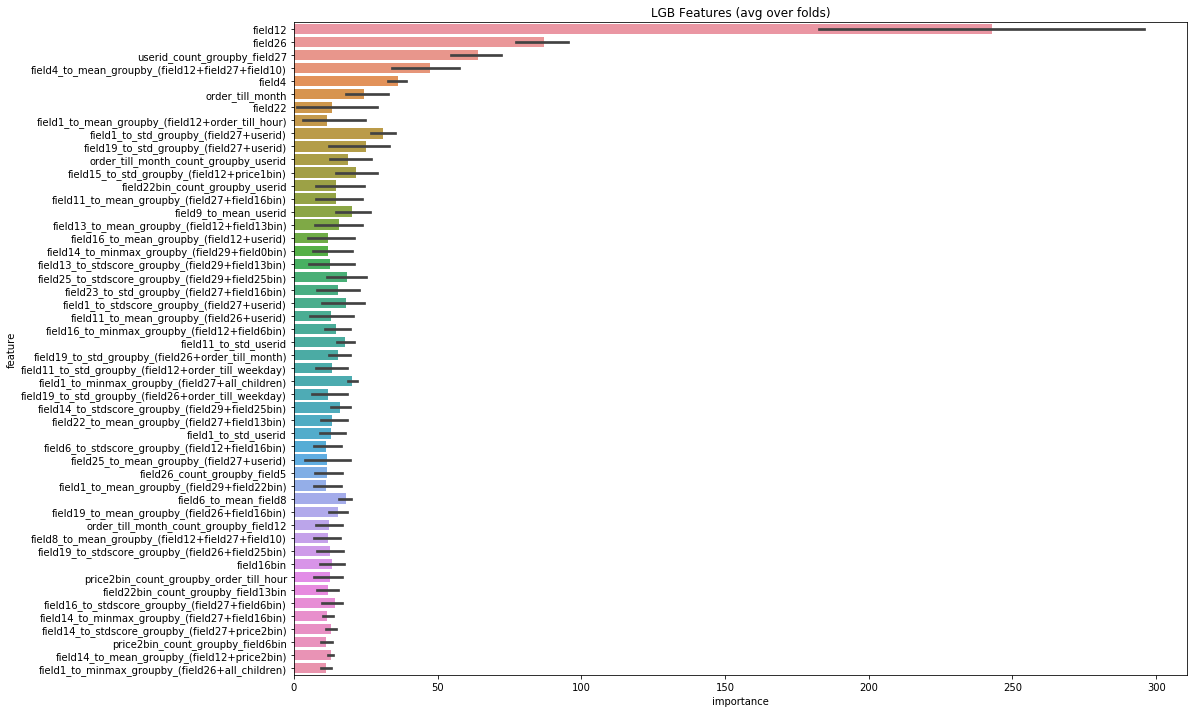

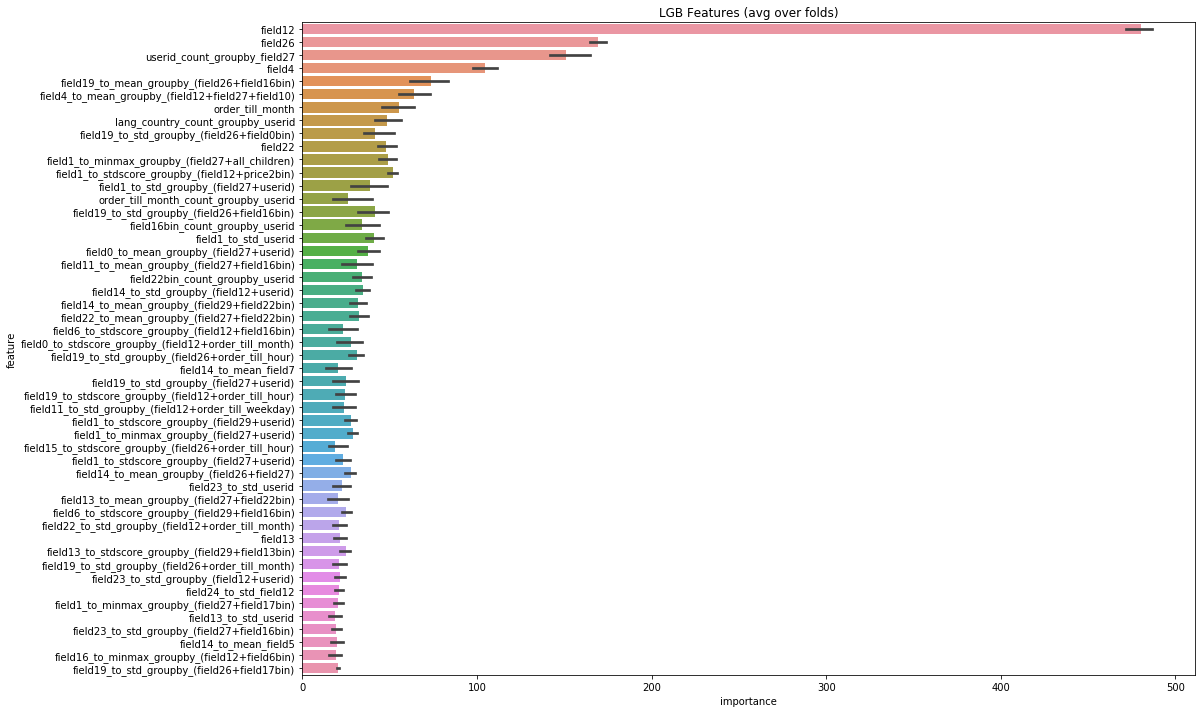

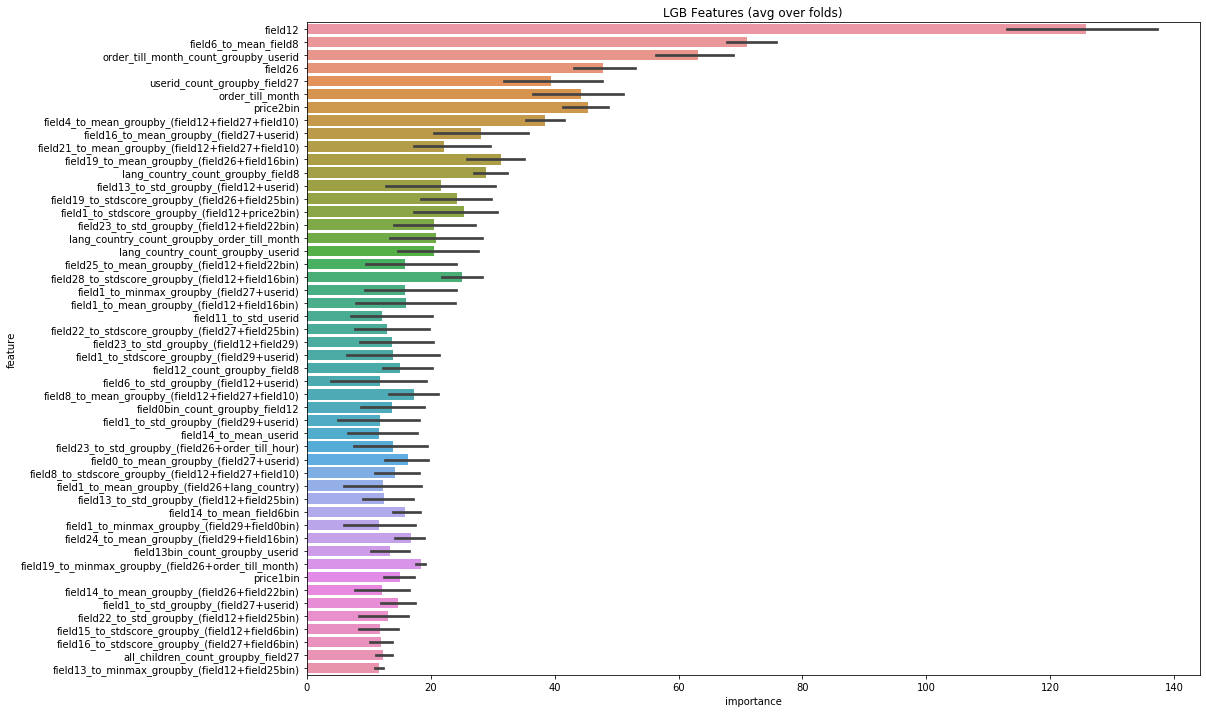

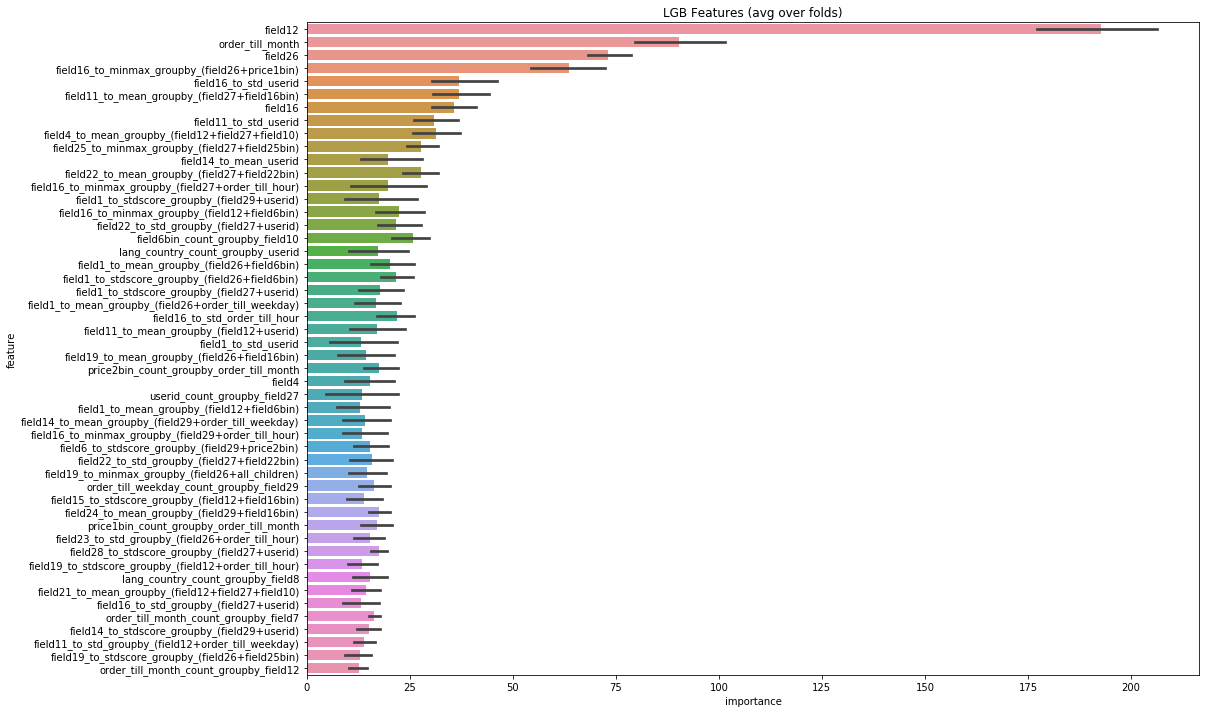

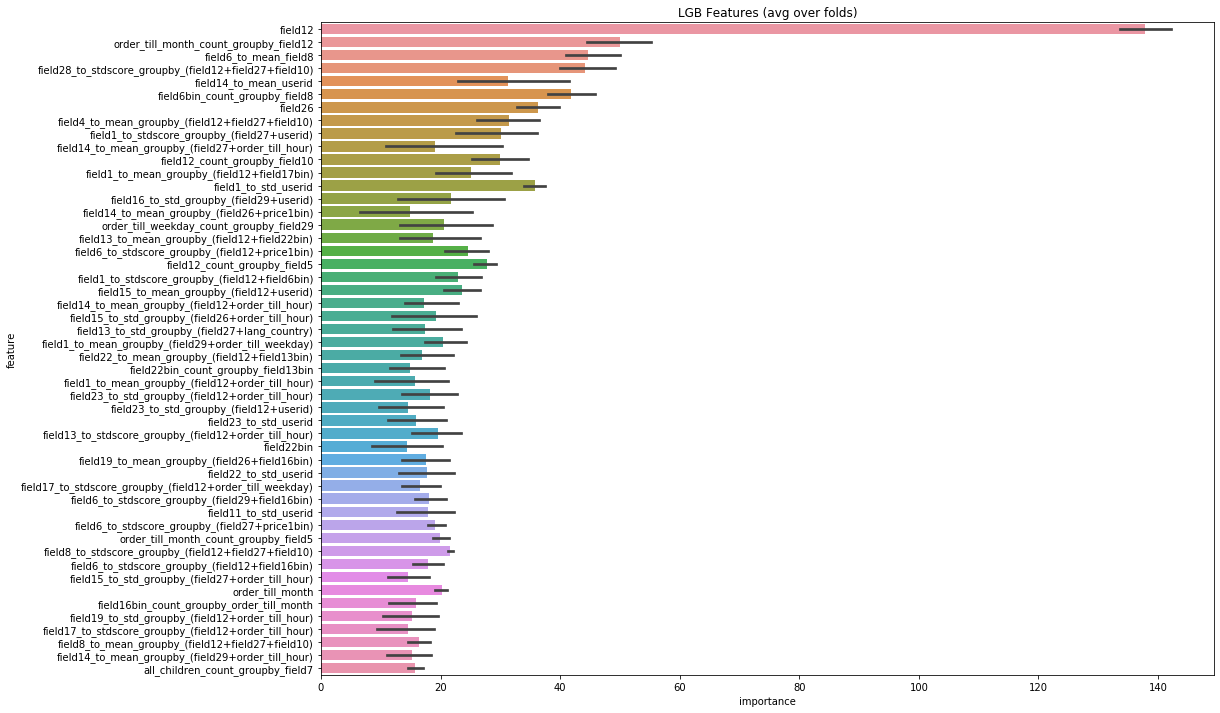

In [47]:
from sklearn.model_selection import GroupKFold, KFold

data = best_features
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}'].astype(np.uint8)
    del data_filtered
    gc.collect()
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
    params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
             }
    train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 3000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.reset_index(drop=True).to_csv(f'temp/submission2-{t}.csv')

In [49]:
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'temp/submission2-{t}.csv')

## Results

### NO FE. initial

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

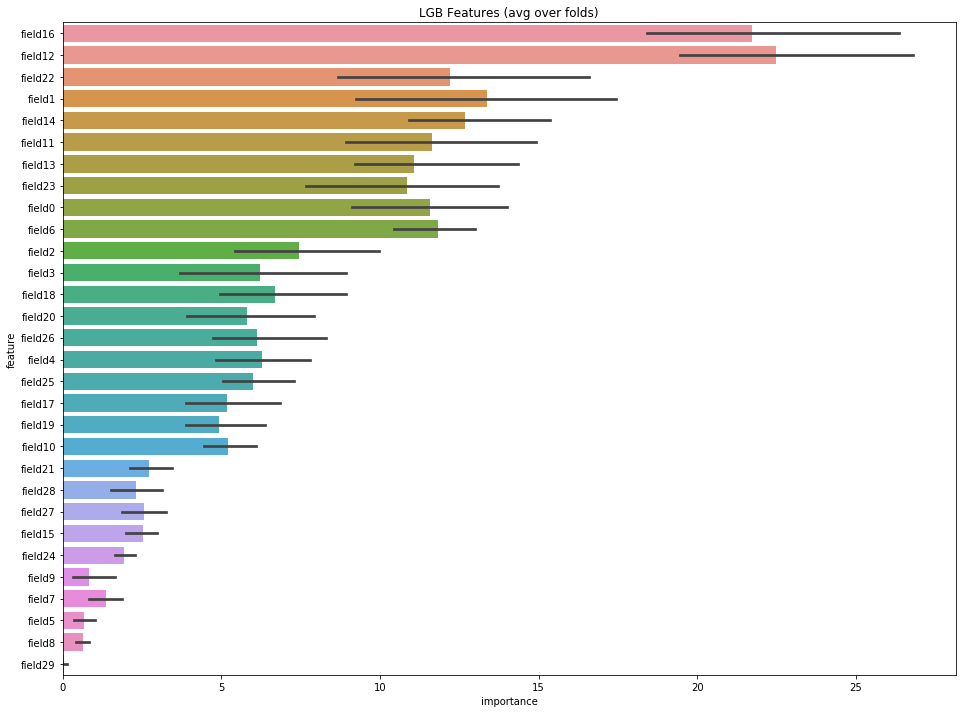

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### add first aggregate node

Fold 1 started at Sun Dec 15 20:21:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.892444	training's auc: 0.892444	valid_1's auc: 0.672213	valid_1's auc: 0.672213
Early stopping, best iteration is:
[67]	training's auc: 0.857729	training's auc: 0.857729	valid_1's auc: 0.676682	valid_1's auc: 0.676682
Fold 2 started at Sun Dec 15 20:21:38 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890783	training's auc: 0.890783	valid_1's auc: 0.705956	valid_1's auc: 0.705956
Early stopping, best iteration is:
[40]	training's auc: 0.817173	training's auc: 0.817173	valid_1's auc: 0.72028	valid_1's auc: 0.720279
Fold 3 started at Sun Dec 15 20:22:05 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890927	training's auc: 0.890927	valid_1's auc: 0.688385	valid_1's auc: 0.688385
Early stopping, best iteration is:
[33]	training's auc: 0.803194	training's auc: 0.803194	valid

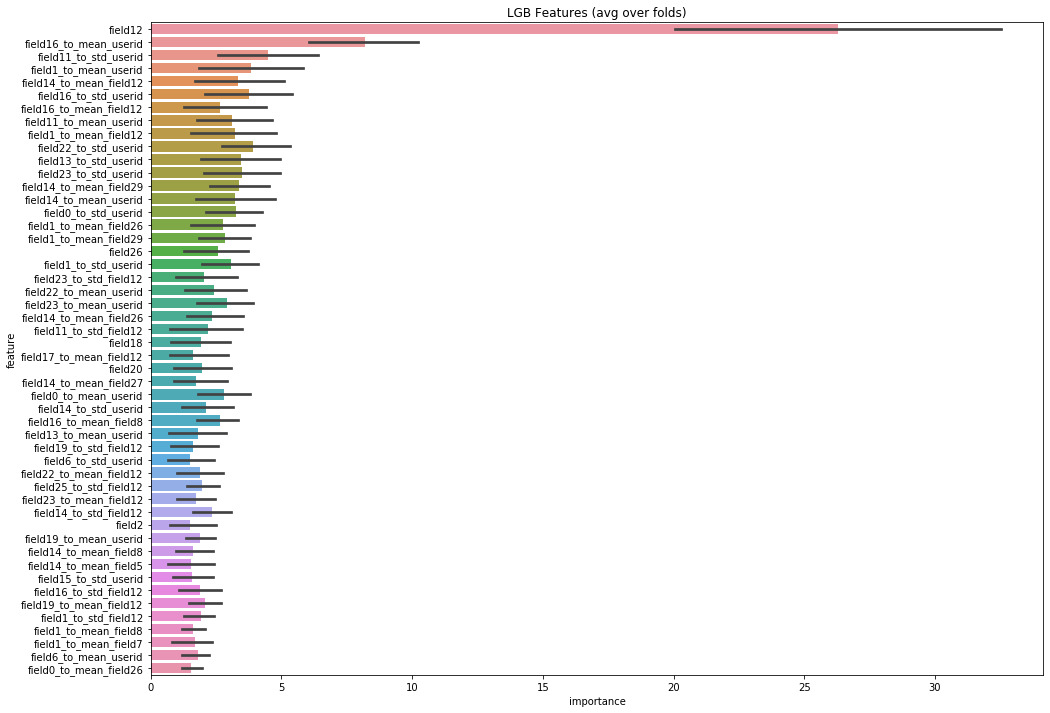

In [13]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### More aggregates

Fold 1 started at Mon Dec 16 23:23:56 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904606	training's auc: 0.904606	valid_1's auc: 0.671887	valid_1's auc: 0.671887
Early stopping, best iteration is:
[50]	training's auc: 0.847829	training's auc: 0.847829	valid_1's auc: 0.676644	valid_1's auc: 0.676644
Fold 2 started at Mon Dec 16 23:24:55 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900505	training's auc: 0.900505	valid_1's auc: 0.712615	valid_1's auc: 0.712615
Early stopping, best iteration is:
[34]	training's auc: 0.810291	training's auc: 0.810291	valid_1's auc: 0.718987	valid_1's auc: 0.718985
Fold 3 started at Mon Dec 16 23:25:42 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900145	training's auc: 0.900145	valid_1's auc: 0.694774	valid_1's auc: 0.694774
Early stopping, best iteration is:
[46]	training's auc: 0.84242	training's auc: 0.84242	valid_

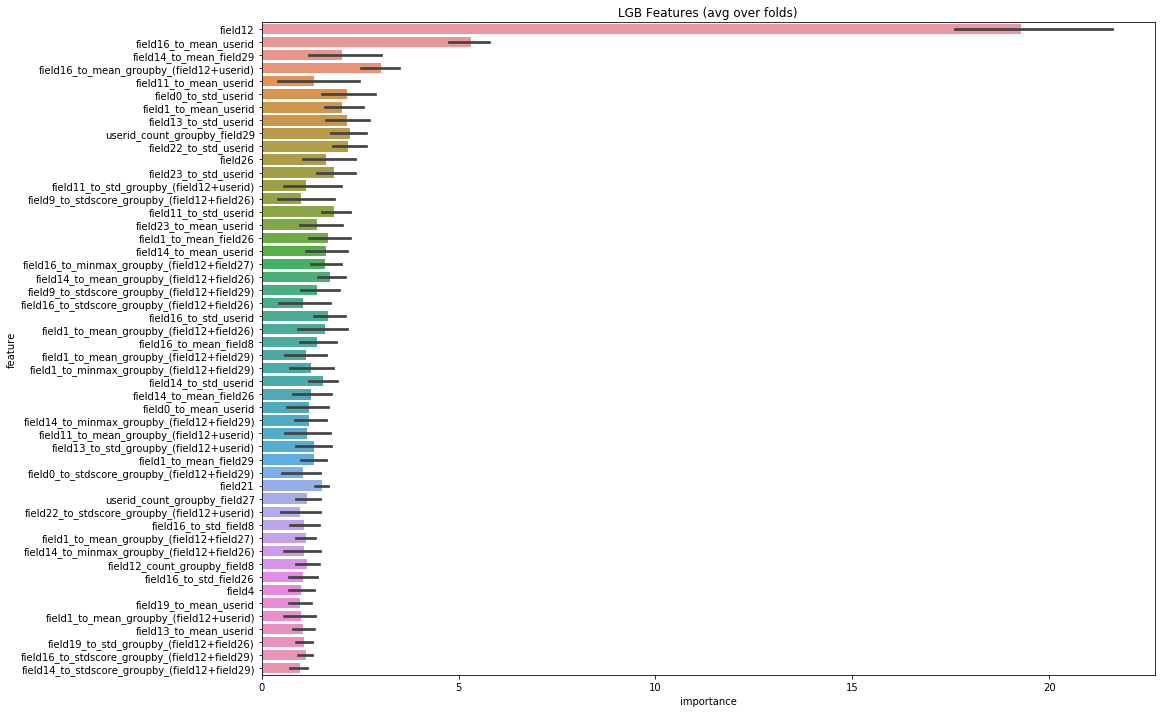

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### Aggs+rfe+tune params (0.6847) - submission_rfe-12-19-20-54.csv

Fold 1 started at Wed Dec 18 21:29:43 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784354	training's auc: 0.784353	valid_1's auc: 0.671344	valid_1's auc: 0.671339
[200]	training's auc: 0.828908	training's auc: 0.828908	valid_1's auc: 0.676033	valid_1's auc: 0.676032
[300]	training's auc: 0.866599	training's auc: 0.866599	valid_1's auc: 0.678715	valid_1's auc: 0.678715
[400]	training's auc: 0.894881	training's auc: 0.894881	valid_1's auc: 0.679986	valid_1's auc: 0.679986
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Fold 2 started at Wed Dec 18 21:32:46 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771693	training's auc: 0.771689	valid_1's auc: 0.712078	valid_1's auc: 0.71208
[200]	training's auc:

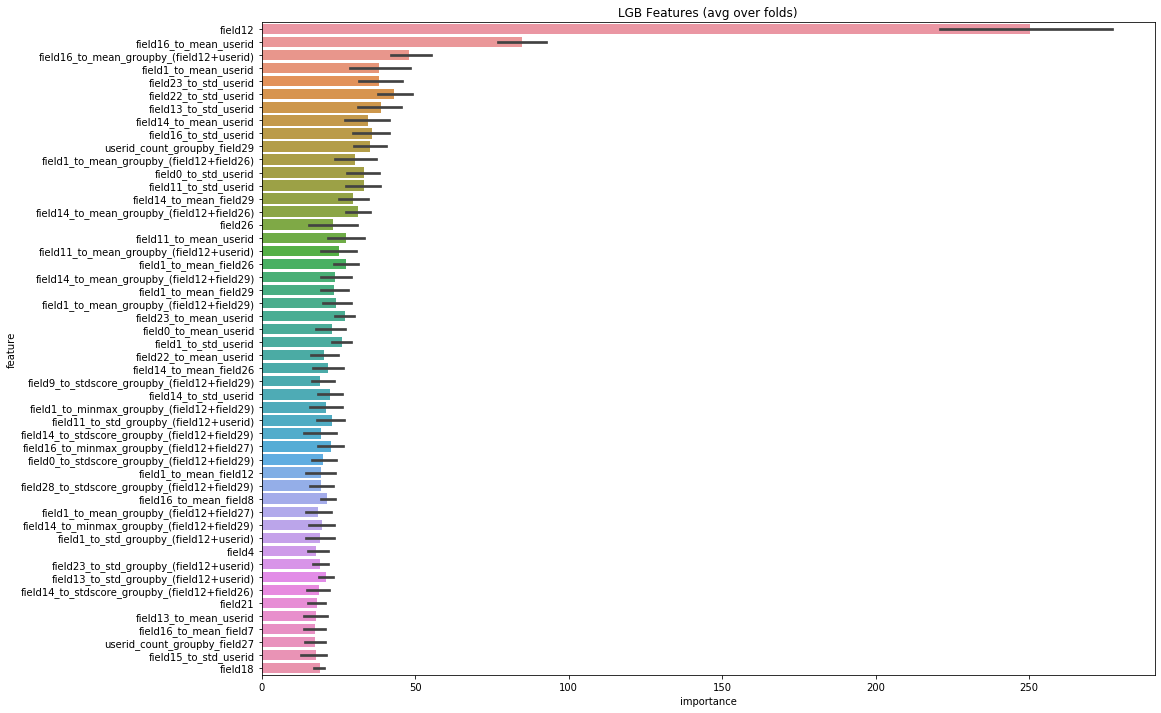

In [19]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)